In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
import praw #(Reddit API)

In [22]:
reddit = praw.Reddit(
    client_id="oDDWZMS0eOtbkZBkLZmpew",  # Your client ID
    client_secret="zXmwJstMA9d2myV3auhuZvJ7WFS_zA",  # Your secret key
    user_agent="script:panosplagos:v1.0 (by u/panosplagos)"  # Custom user agent
)

In [38]:
subreddit = reddit.subreddit("depression")
posts = subreddit.hot(limit=500) # Fetch the top 500 posts
comments = []
#This approach creates a large dataset of comments
for post in posts:
    post.comments.replace_more(limit=0)  
    # Ensure all comments load. This Line will fetch you comments using praw. Reddit does not return all comments immediately.
#Instead, it groups some of them into "MoreComments" objects to save bandwidth and improve performance.
#The replace_more(limit=0) method removes these placeholders and ensures that you get only actual comments.
    for comment in post.comments.list():
        comments.append(comment.body)
print(f"Extracted {len(comments)} comments")

Extracted 2304 comments


In [41]:
vader = SentimentIntensityAnalyzer()
sentiment_results = []
for comment in comments:
    sentiment = vader.polarity_scores(comment)
    sentiment_results.append((comment, sentiment["compound"]))
#Categorizing Comments into Positive, Neutral and Negative
positive = [c[0] for c in sentiment_results if c[1] > 0.05]
neutral = [c[0] for c in sentiment_results if -0.05 <= c[1] <= 0.05]
negative = [c[0] for c in sentiment_results if c[1] < -0.05]
print(f"Positive: {len(positive)}, Neutral: {len(neutral)}, Negative: {len(negative)}")

Positive: 1172, Neutral: 321, Negative: 811


In [42]:
df = pd.DataFrame(sentiment_results, columns = ["comment", "sentiment_score"])

In [43]:
df.head()

,comment,sentiment_score
0,Understood and I apologise if I forget in the ...,0.1779
1,[removed],0.0000
2,Biggest Problem on private talks may be that y...,-0.2406
3,I have to agree with this. I know that people ...,0.6476
4,Great rule! I’ve never thought about things yo...,0.8821


In [44]:
sns.set(style="whitegrid")

In [45]:
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

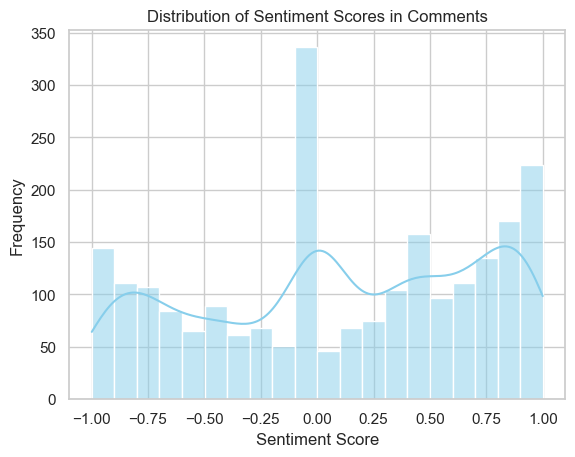

In [46]:
sns.histplot(df["sentiment_score"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Sentiment Scores in Comments")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

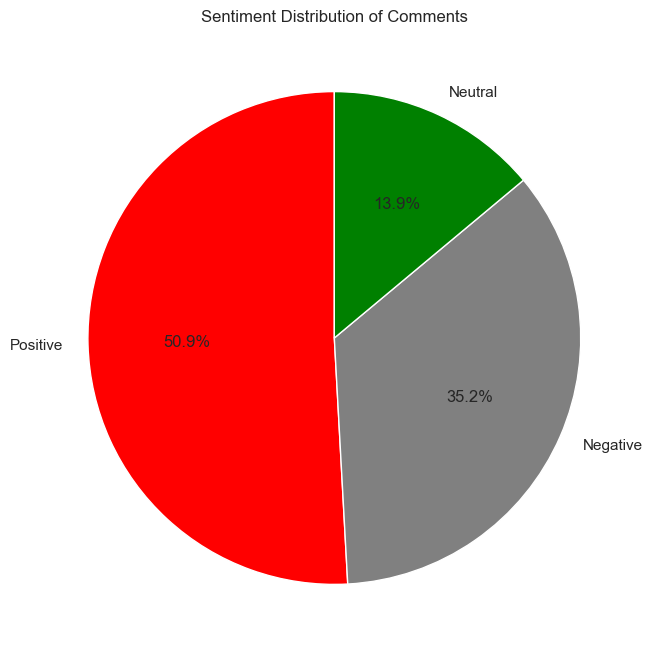

In [49]:
#Categorize Sentiment
df["Sentiment_Category"] = pd.cut(df["sentiment_score"], bins=[-1,-0.05,0.05,1], labels= ["Negative","Neutral","Positive"])
#Count Sentiment Categories
sentiment_counts = df["Sentiment_Category"].value_counts()

#Plot Pie Chart
plt.figure(figsize=(8,8))
sentiment_counts.plot.pie(autopct="%1.1f%%",colors=["red","gray","green"], startangle=90)
plt.title("Sentiment Distribution of Comments")
plt.ylabel("")
plt.show()

In [57]:
#Topic Modeling: Understanding the Topics discussed. Applying Topic Modeling techbiques, like LDA, to group comments by topic and analyze sentiment for each group.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#Vectorize Comments
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["comment"])

#Apply LDA (Topic Modeling)
lda = LatentDirichletAllocation(n_components=5, random_state =42)
lda.fit(X)

#Print the Top Words in each Topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]])
    print("\n")

Topic #0:
['just', 'really', 'like', 'life', 've', 'years', 'did', 'better', 'hope', 'feeling']


Topic #1:
['just', 'better', 'love', 'like', 'people', 'good', 'feel', 'need', 'want', 'women']


Topic #2:
['removed', 'think', 'deleted', 've', 'just', 'depression', 'like', 'suffering', 'remember', 'worst']


Topic #3:
['life', 'years', 'better', 'just', 'thanks', 'people', 'maybe', 'support', 'depression', 'day']


Topic #4:
['just', 'don', 'like', 'people', 'feel', 'life', 'better', 'know', 'things', 'think']




In [59]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = ["just","don","like","really","ve","people","think"]
combined_stopwords = list(ENGLISH_STOP_WORDS) + custom_stopwords
vectorizer= CountVectorizer(stop_words=combined_stopwords)
X = vectorizer.fit_transform(df["comment"])
lda = LatentDirichletAllocation(n_components=5, random_state =42)
lda.fit(X)

#Print the Top Words in each Topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]])
    print("\n")

Topic #0:
['women', 'men', 'feel', 'depression', 'life', 'know', 'bad', 'years', 'want', 'help']


Topic #1:
['life', 'better', 'feel', 'things', 'time', 'know', 'want', 'way', 'help', 'make']


Topic #2:
['good', 'help', 'things', 'life', 'need', 'thing', 'want', 'depression', 'try', 'better']


Topic #3:
['know', 'black', 'feel', 'life', 'sorry', 'way', 'love', 'try', 'world', 'white']


Topic #4:
['thank', 'love', 'live', 'shit', 'que', 'time', 'need', 'hate', 'parents', 'feel']




In [60]:
from wordcloud import WordCloud

In [65]:
comments_text= " ".join(df["comment"])
wordcloud= WordCloud(stopwords= combined_stopwords, background_color="white",width=800, height=400).generate(comments_text)
sns.set_theme(style="darkgrid")

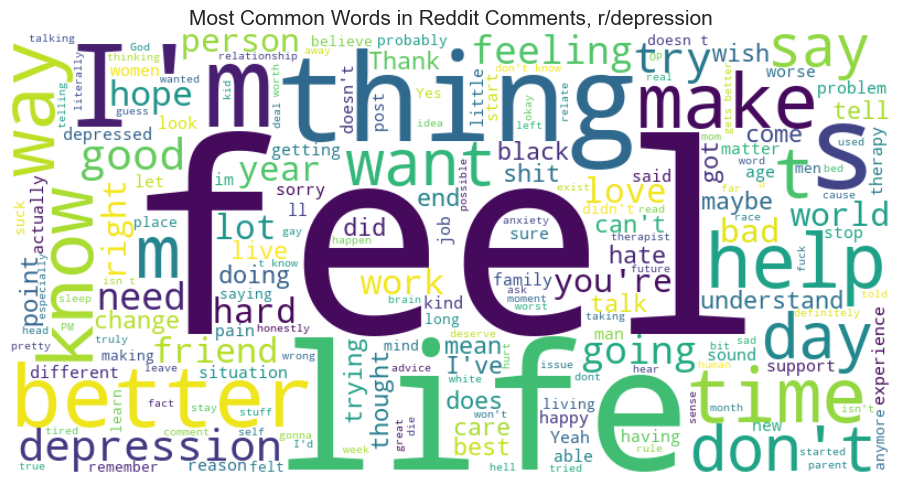

In [66]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reddit Comments, r/depression", fontsize=15)
plt.tight_layout()
plt.show()

In [69]:
#Analysis of Cognitive Appraisals
from textblob import TextBlob

In [75]:
df["sentiment"] = df["comment"].apply(lambda x: TextBlob(x).sentiment.polarity)
#Categorize Sentiment as Positive, Negative or Neutral based on Polarity
df["sentiment_label"] = df["sentiment"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))
print(df["sentiment_label"].value_counts())

sentiment_label
Positive    1018
Neutral      723
Negative     563
Name: count, dtype: int64


In [76]:
sia = SentimentIntensityAnalyzer()
df["vader_sentiment"] = df["comment"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["vader_sentiment_label"] = df["vader_sentiment"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))
print(df["vader_sentiment_label"].value_counts())

vader_sentiment_label
Positive    1172
Negative     811
Neutral      321
Name: count, dtype: int64


In [77]:
#Analyzing Cognitive Reframing
#Using common words that one uses when they try to reframe negative aspects into positive ones.
reframing_keywords = ["bright side", "silver lining", "change of perspective", "next time", "learning from failure"]
df["cognitive_reframing"] = df["comment"].apply(lambda x: any(keyword in x.lower() for keyword in reframing_keywords))
print(df["cognitive_reframing"].value_counts())

cognitive_reframing
False    2300
True        4
Name: count, dtype: int64
